# Assignment:
Beat the performance of my Lasso regression by using different feature engineering steps ONLY!!.

The performance of my current model, as shown in this notebook is:

      - test rmse: 44798.497576784845
      - test r2: 0.7079639526659389
To beat my model you will need a test r2 bigger than 0.71 and a rmse smaller than 44798.

## Conditions:
      - You MUST NOT change the hyperparameters of the Lasso.
      - You MUST use the same seeds in Lasso and train_test_split as I show in this notebook (random_state)
      - You MUST use all the features of the dataset (except Id) - you MUST NOT select features

## House Prices Dataset

In [1]:
from math import sqrt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# for the model
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.impute import KNNImputer
from sklearn.compose import ColumnTransformer

# for feature engineering
from sklearn.preprocessing import StandardScaler
from feature_engine import imputation as mdi
from feature_engine import discretisation as dsc
from feature_engine import encoding as ce
from feature_engine import transformation as vt

### Load Datasets

In [2]:
data = pd.read_csv('../Documents/house-prices.csv')

In [3]:
# make lists of variable types

categorical = [var for var in data.columns if data[var].dtype == 'O']

year_vars = [var for var in data.columns if 'Yr' in var or 'Year' in var]

discrete = [
    var for var in data.columns if data[var].dtype != 'O'
    and len(data[var].unique()) < 20 and var not in year_vars
]

numerical = [
    var for var in data.columns if data[var].dtype != 'O'
    if var not in discrete and var not in ['Id', 'SalePrice']
    and var not in year_vars
]

print('There are {} continuous variables'.format(len(numerical)))
print('There are {} discrete variables'.format(len(discrete)))
print('There are {} temporal variables'.format(len(year_vars)))
print('There are {} categorical variables'.format(len(categorical)))

There are 18 continuous variables
There are 14 discrete variables
There are 4 temporal variables
There are 43 categorical variables


### Seperate into train and Test Set

In [4]:
# IMPORTANT: keep the random_state to zero for reproducibility
# Let's separate into train and test set

X_train, X_test, y_train, y_test = train_test_split(data.drop(
    ['Id', 'SalePrice'], axis=1),
    data['SalePrice'],
    test_size=0.1,
    random_state=0)

In [5]:
# calculate elapsed time

def elapsed_years(df, var):
    # capture difference between year variable and
    # year the house was sold
    
    df[var] = df['YrSold'] - df[var]
    return df

for var in ['YearBuilt', 'YearRemodAdd', 'GarageYrBlt']:
    X_train = elapsed_years(X_train, var)
    X_test = elapsed_years(X_test, var)

In [6]:
# drop YrSold
X_train.drop('YrSold', axis=1, inplace=True)
X_test.drop('YrSold', axis=1, inplace=True)

In [7]:
# capture the column names for use later in the notebook
final_columns = X_train.columns

## Find Variables to Log Transform

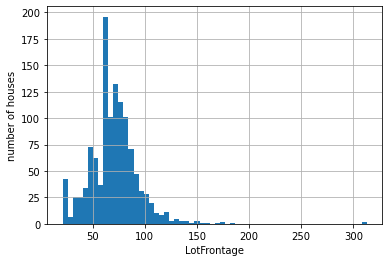

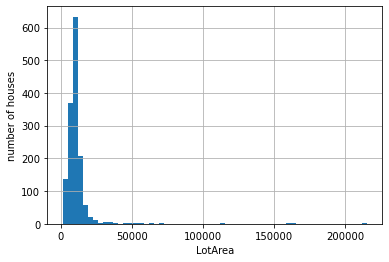

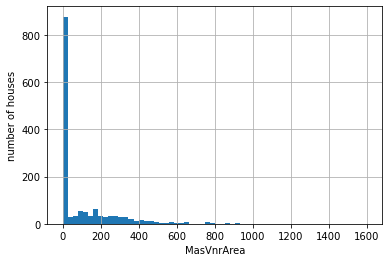

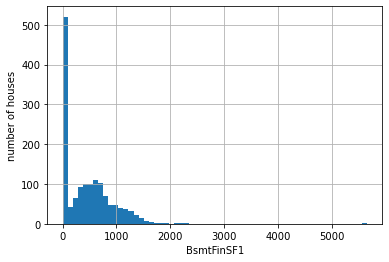

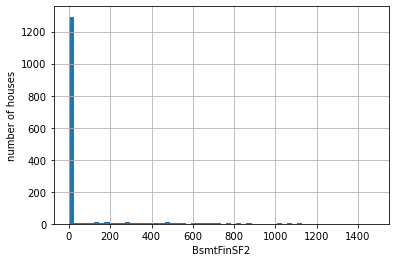

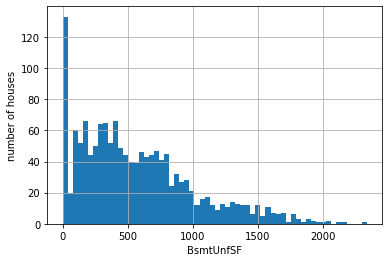

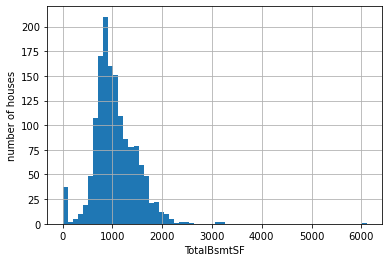

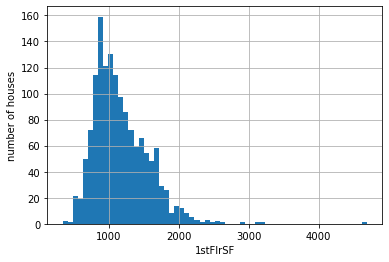

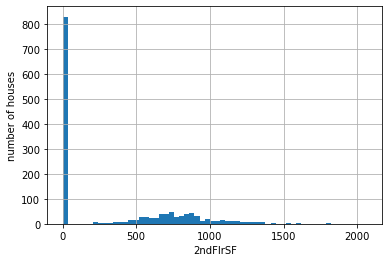

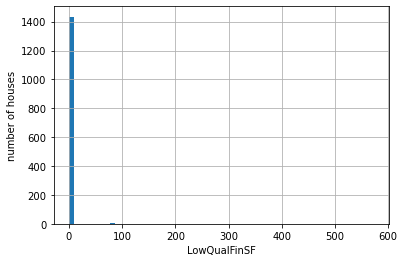

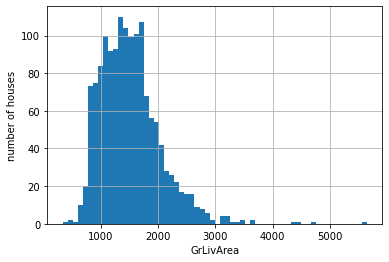

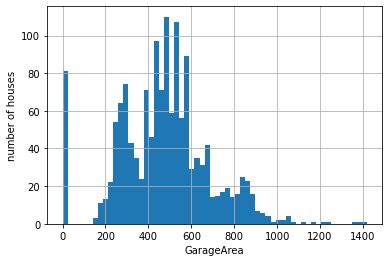

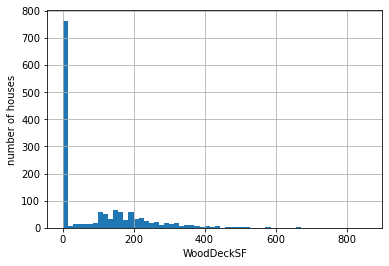

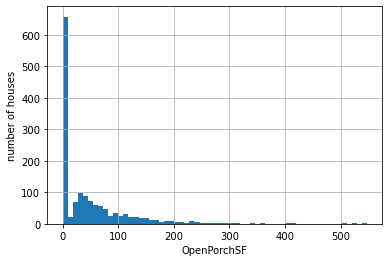

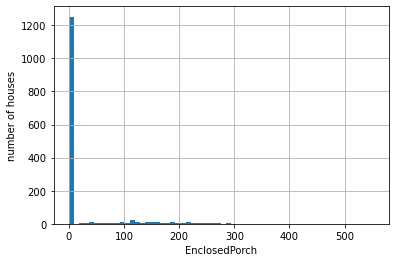

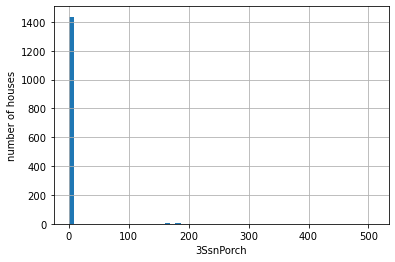

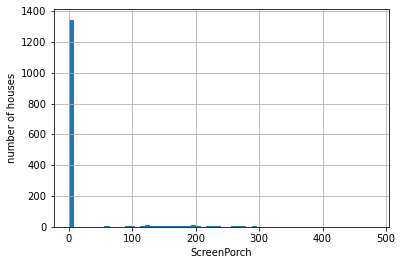

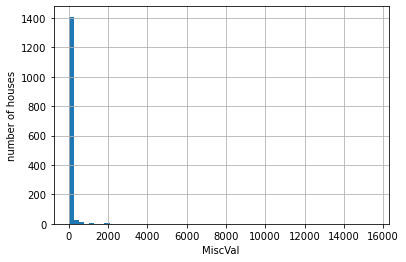

In [8]:
for var in numerical:
    plt.figure(figsize=(6,4))
    fig = data[var].hist(bins=60)
    fig.set_ylabel('number of houses')
    fig.set_xlabel(var)

In [9]:
numericals_to_log = ['TotalBsmtSF', '1stFlrSF', 'GrLivArea', 'GarageArea']

vars_to_discret = [var for var in numerical if var not in numericals_to_log]

## Feature Engineering Pipeline

In [10]:
# I will treat discrete variables as if they were categorical
# to treat discrete as categorical using Feature-engine
# we need to re-cast them as object

X_train[discrete] = X_train[discrete].astype('O')
X_test[discrete] = X_test[discrete].astype('O')

In [54]:
# When to use mean/median imputation -- No more than 5% of the variable contains missing data
# Therefore, will check the percentage of missing data in the columns  
result = X_train.isnull().mean().sort_values(ascending=False)

for i in range(len(result.index)):
    var = result.index[i]
    if var in numerical:
        var_type = "numerical"
    elif var in discrete:
        var_type = "discrete"
    elif var in year_vars:
        var_type = "year_vars"
    elif var in categorical:
        var_type = "categorical"
    print(f"{var} in {var_type} with {result.values[i] > 0.06}")



PoolQC in categorical with True
MiscFeature in categorical with True
Alley in categorical with True
Fence in categorical with True
FireplaceQu in categorical with True
LotFrontage in numerical with True
GarageYrBlt in year_vars with False
GarageType in categorical with False
GarageFinish in categorical with False
GarageQual in categorical with False
GarageCond in categorical with False
BsmtFinType2 in categorical with False
BsmtExposure in categorical with False
BsmtCond in categorical with False
BsmtFinType1 in categorical with False
BsmtQual in categorical with False
MasVnrType in categorical with False
MasVnrArea in numerical with False
Electrical in categorical with False
TotRmsAbvGrd in discrete with False
Functional in categorical with False
KitchenAbvGr in discrete with False
BedroomAbvGr in discrete with False
HalfBath in discrete with False
FullBath in discrete with False
BsmtHalfBath in discrete with False
BsmtFullBath in discrete with False
KitchenQual in categorical with Fa

In [11]:
house_pipe = Pipeline([
    
    #log transformation
    ('log_transform', vt.PowerTransformer(variables=numericals_to_log)),
    
    
    # missing data imputation - section 4
    #('missing_ind', mdi.AddMissingIndicator(variables=['LotFrontage', 'MasVnrArea',  'GarageYrBlt'])),
    ('imputer_num', mdi.MeanMedianImputer(imputation_method='median',variables=['LotFrontage', 'MasVnrArea',  'GarageYrBlt'])),
    ('missing_ind_catigorical', mdi.AddMissingIndicator(variables=categorical)),
    ('imputer_cat', mdi.CategoricalImputer(imputation_method='frequent', variables=categorical)),
    
    
    #categorical encoding
    ('rare_label_enc', ce.RareLabelEncoder(tol=0.03, n_categories=10, variables=categorical+discrete)),
    ('categorical_enc', ce.OneHotEncoder(top_categories=10 , variables=categorical+discrete)),
    #('cat_encoding', ce.OrdinalEncoder(encoding_method='ordered', variables=categorical+discrete)),

    
    #discretisation + encoding
    #('discretisation', dsc.EqualFrequencyDiscretiser(q=12, return_object=True, variables=numerical)),
    ('discretisation', dsc.EqualFrequencyDiscretiser(q=12, return_object=True, variables=vars_to_discret)),
    #('encoding', ce.OrdinalEncoder(encoding_method='ordered', variables=numerical)),
    #('encoding', ce.OneHotEncoder(variables=numerical)),
    ('encoding', ce.OneHotEncoder(variables=vars_to_discret)),
    
    
    #feature Scaling - section 10
    ('scaler', StandardScaler()),

    
    #regression
    ('lasso', Lasso(random_state=0))
    
    
    
])

In [12]:

# let's fit the pipeline
house_pipe.fit(X_train, y_train)

# let's get the predictions
X_train_preds = house_pipe.predict(X_train)
X_test_preds = house_pipe.predict(X_test)

C:\Users\benva\anaconda3\lib\site-packages\feature_engine\encoding\rare_label.py:179: UserWarning: The number of unique categories for variable MSZoning is less than that indicated in n_categories. Thus, all categories will be considered frequent
  warnings.warn(
C:\Users\benva\anaconda3\lib\site-packages\feature_engine\encoding\rare_label.py:179: UserWarning: The number of unique categories for variable Street is less than that indicated in n_categories. Thus, all categories will be considered frequent
  warnings.warn(
C:\Users\benva\anaconda3\lib\site-packages\feature_engine\encoding\rare_label.py:179: UserWarning: The number of unique categories for variable Alley is less than that indicated in n_categories. Thus, all categories will be considered frequent
  warnings.warn(
C:\Users\benva\anaconda3\lib\site-packages\feature_engine\encoding\rare_label.py:179: UserWarning: The number of unique categories for variable LotShape is less than that indicated in n_categories. Thus, all categ

In [13]:
# check model performance:

print('train mse: {}'.format(mean_squared_error(y_train, X_train_preds)))
print('train rmse: {}'.format(sqrt(mean_squared_error(y_train, X_train_preds))))
print('train r2: {}'.format(r2_score(y_train, X_train_preds)))
print()
print('test mse: {}'.format(mean_squared_error(y_test, X_test_preds)))
print('test rmse: {}'.format(sqrt(mean_squared_error(y_test, X_test_preds))))
print('test r2: {}'.format(r2_score(y_test, X_test_preds)))

# Original results:
# train mse: 1035269885.2749033
# train rmse: 32175.610099497775
# train r2: 0.8341931836507989

# test mse: 2006905385.1371987
# test rmse: 44798.49757678486
# test r2: 0.7079639526659387

train mse: 371940558.0843521
train rmse: 19285.76050054423
train r2: 0.9404307218008802

test mse: 1071378969.4555761
test rmse: 32731.92584397649
test r2: 0.8440976431904602


Text(0, 0.5, 'Predicted Price')

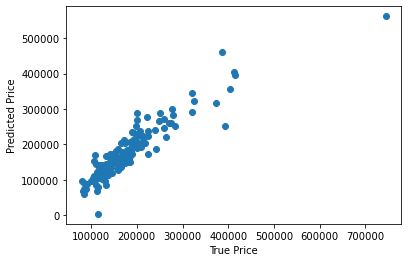

In [14]:
# plot predictions vs real value

plt.scatter(y_test,X_test_preds)
plt.xlabel('True Price')
plt.ylabel('Predicted Price')